In [1]:
import matplotlib.pyplot as plt
import nnfs
import numpy as np
from nnfs.datasets import spiral_data, sine_data
from matplotlib import ticker, cm
import time

In [3]:
%matplotlib --list

Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'ipympl', 'macosx', 'module://matplotlib_inline.backend_inline', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'widget', 'wx', 'wx', 'wxagg', 'wxcairo']


In [22]:
%matplotlib inline
# plt.ioff()
nnfs.init()
plt.style.use("seaborn-v0_8-bright")



In [ ]:
class Model:

    def __init__(self, epochs):
        self.dense_layers = []
        self.epochs = epochs
        self.optimizer = None
        self.flag = False
        self.X = None
        self.y = None

    def add_dense(
        self,
        n_inputs,
        n_neurons,
        activation,
        L1_weight_regularizer=0,
        L2_weight_regularizer=0,
        L1_bias_regularizer=0,
        L2_bias_regularizer=0,
    ):
        dense = Dense(
            n_inputs,
            n_neurons,
            activation,
            L1_weight_regularizer,
            L2_weight_regularizer,
            L1_bias_regularizer,
            L2_bias_regularizer,
        )
        self.dense_layers.append(dense)

    def add_dropout(self, rate=0.1):
        self.dense_layers.append(Dropout(rate))

    def add_loss(self, loss_function):

        if (
            loss_function == Categorical_Cross_Entropy
            and self.dense_layers[-1].activation.__class__.__name__ == "Softmax"
        ):
            self.dense_layers[-1].activation = Softmax_Categorical_Cross_Entropy_Loss()
            self.flag = True
            # print(self.dense_layers)
        self.loss_function = loss_function()

    def add_optimizer(self, optimizer, **params):
        self.optimizer = optimizer(**params)

    def fit(self, X, y):
        self.X = X
        self.y = y
        accuracy_precision = np.std(self.y) / 250

        for epoch in range(self.epochs):

            layer_output = self.X
            regularization_loss = 0
            for layer in self.dense_layers:
                layer_output = layer.forward(layer_output)
                if layer.TYPE == "dense":
                    regularization_loss += layer.regularization()

            data_loss = self.loss_function.calculate(layer_output, self.y)
            loss = data_loss + regularization_loss

            if self.loss_function.__class__.__name__ == "Categorical_Cross_Entropy":
                if len(self.y.shape) == 2:
                    self.y = np.argmax(self.y, axis=1)
                predictions = np.argmax(layer_output, axis=1)
                accuracy = np.mean(predictions == self.y)
            elif self.loss_function.__class__.__name__ == "Binary_Cross_Entropy":
                predictions = (layer_output > 0.5) * 1
                accuracy = np.mean(predictions == self.y)
            elif self.loss_function.__class__.__name__ in ["MAR", "MSE"]:
                predictions = layer_output
                accuracy = np.mean(
                    np.absolute(predictions - self.y) < accuracy_precision
                )

            if not epoch % 100:
                print(
                    f"Epochs: {epoch}, Acc: {accuracy}, Loss: {loss}, Data_Loss:"
                    f" {data_loss}, Reg_Loss: {regularization_loss}, Lr:"
                    f" {self.optimizer.current_learning_rate}"
                )
            reversed_dense_layer = self.dense_layers.copy()
            reversed_dense_layer.reverse()

            if self.flag:

                dvalues = reversed_dense_layer[0].backward(layer_output, self.y)

                n = 1
            else:

                dvalues = self.loss_function.backward(layer_output, self.y)

                n = 0
            for layer in reversed_dense_layer[n:]:
                dvalues = layer.backward(dvalues)
            self.optimizer.pre_update_params()
            for layer in self.dense_layers:
                if layer.TYPE == "dense":

                    self.optimizer.update_params(layer)
            self.optimizer.post_update_params()

    def show_regression(self):
        layer_output = self.X
        for layer in self.dense_layers:
            layer_output = layer.forward(layer_output)
        plt.plot(self.X, self.y)
        plt.plot(self.X, layer_output)

    def show_boundary(self):
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01)
        )
        layer_output = np.c_[xx.ravel(), yy.ravel()]
        for layer in self.dense_layers:
            layer_output = layer.forward(layer_output)
        print(layer_output.shape[1] == 1)
        if layer_output.shape[1] == 1:
            Z = (layer_output > 0.5) * 1
            Z = Z.reshape(xx.shape)
        else:
            Z = np.argmax(layer_output, axis=1).reshape(xx.shape)

        # plt.figure(figsize=(8, 6))
        # plt.contourf(xx, yy, Z, alpha=0.2)
        plt.set_cmap(plt.cm.brg)
        plt.pcolormesh(xx, yy, Z, alpha=0.2, shading="gouraud", snap=True)
        plt.scatter(X[:, 0], X[:, 1], s=10, c=y, alpha=1)

In [6]:
class Dropout:
    def __init__(self, rate) -> None:
        self.rate = 1 - rate
        self.TYPE = "dropout"

    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = (
            np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        )
        self.output = self.inputs * self.binary_mask
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        return self.dinputs

In [7]:
class Dense:

    def __init__(
        self,
        n_inputs,
        n_neurons,
        activation,
        L1_weight_regularizer=0,
        L2_weight_regularizer=0,
        L1_bias_regularizer=0,
        L2_bias_regularizer=0,
    ):
        self.TYPE = "dense"
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.L1_weight_regularizer = L1_weight_regularizer
        self.L2_weight_regularizer = L2_weight_regularizer
        self.L1_bias_regularizer = L1_bias_regularizer
        self.L2_bias_regularizer = L2_bias_regularizer
        self.activation = activation()

    def forward(self, inputs, *args):
        self.inputs = inputs
        self.output = self.activation.forward(
            np.dot(self.inputs, self.weights) + self.biases, *args
        )
        return self.output

    def regularization(self):
        regularization = 0
        if self.L1_weight_regularizer > 0:
            regularization += self.L1_weight_regularizer * np.sum(np.abs(self.weights))
        if self.L2_weight_regularizer > 0:
            regularization += self.L2_weight_regularizer * np.sum(self.weights**2)
        if self.L1_bias_regularizer > 0:
            regularization += self.L1_bias_regularizer * np.sum(np.abs(self.biases))
        if self.L2_bias_regularizer > 0:
            regularization += self.L2_bias_regularizer * np.sum(self.biases**2)
        return regularization

    # dvalues is derivative we got from previous neurons
    def backward(self, dvalues, *args):
        dvalues = self.activation.backward(dvalues, *args)

        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        if self.L1_weight_regularizer > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.L1_weight_regularizer * dL1

        if self.L2_weight_regularizer > 0:
            self.dweights += 2 * self.L2_weight_regularizer * self.weights

        if self.L1_bias_regularizer > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.L1_bias_regularizer * dL1

        if self.L2_bias_regularizer > 0:
            self.dbiases += 2 * self.L2_bias_regularizer * self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

In [8]:
class ReLU:

    def forward(self, inputs, *args):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        return self.output

    def backward(self, dvalues, *args):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        return self.dinputs


class Softmax:

    def forward(self, inputs, *args):
        self.inputs = inputs
        exp_values = np.exp(
            inputs - np.max(inputs, axis=1, keepdims=True), dtype=np.double
        )
        # if not exp_values.all():
        #     print(exp_values)
        #     input()
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        return self.output

    def backward(self, dvalues, *args):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(
            zip(self.output, dvalues)
        ):
            single_output = single_output.reshape(1, -1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(
                single_output.T, single_output
            )

            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

        return self.dinputs


class Sigmoid:
    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function

        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output
        return self.dinputs


class Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
        return self.output

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        return self.dinputs

In [9]:
class Loss:

    def calculate(self, y_pred, y_actual, *args):
        sample_losses = self.forward(y_pred, y_actual)
        data_loss = np.mean(sample_losses)
        return data_loss


class Binary_Cross_Entropy(Loss):
    def forward(self, y_pred, y_actual):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate sample-wise loss
        sample_losses = -(
            y_actual * np.log(y_pred_clipped)
            + (1 - y_actual) * np.log(1 - y_pred_clipped)
        )
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_actual):
        samples = len(dvalues)
        output = len(dvalues[0])
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        self.dinputs = (
            -(y_actual / clipped_dvalues - (1 - y_actual) / (1 - clipped_dvalues))
            / output
        )

        self.dinputs = self.dinputs / samples
        return self.dinputs


class Categorical_Cross_Entropy(Loss):

    def forward(self, y_pred, y_actual, *args):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        correct_confidences = []
        if len(y_actual.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_actual]
        elif len(y_actual.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_actual, axis=1)
        negative_log = -np.log(correct_confidences)
        return negative_log

    def backward(self, dvalues, y_true, *args):

        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        # if not dvalues.all():
        #     print(dvalues)
        #     input()
        # print(np.where(dvalues == 0))
        self.dinputs = -y_true / dvalues

        self.dinputs = self.dinputs / samples
        return self.dinputs


class Softmax_Categorical_Cross_Entropy_Loss:

    def __init__(self):
        self.activation = Softmax()
        self.loss = Categorical_Cross_Entropy()

    def forward(self, inputs, *args):
        self.activation.forward(inputs)
        self.output = self.activation.output
        # return self.loss.calculate(self.output, y_actual)
        return self.output

    def backward(self, dvalues, *args):
        y_actual = args[0]
        samples = len(dvalues)
        if len(y_actual.shape) == 2:
            y_actual = np.argmax(y_actual, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_actual] -= 1
        self.dinputs = self.dinputs / samples
        return self.dinputs


class MSE(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred) ** 2, axis=-1)
        # Return losses
        return sample_losses

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs


class MAR(Loss):
    def forward(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

In [10]:
class SGD:

    def __init__(self, learning_rate=1, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_update = (
                self.momentum * layer.weight_momentums
                - self.current_learning_rate * layer.dweights
            )
            layer.weight_momentums = weight_update

            bias_update = (
                self.momentum * layer.bias_momentums
                - self.current_learning_rate * layer.dbiases
            )
            layer.bias_momentums = bias_update
        else:
            weight_update = -self.current_learning_rate * layer.dweights
            bias_update = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_update
        layer.biases += bias_update

    def post_update_params(self):
        self.iterations += 1


class AdaGrad:

    def __init__(self, learning_rate=0.1, decay=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    def update_params(self, layer):

        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache += layer.dweights**2

        layer.bias_cache += layer.dbiases**2

        layer.weights += (-self.current_learning_rate * layer.dweights) / (
            np.sqrt(layer.weight_cache) + self.epsilon
        )
        layer.biases += (-self.current_learning_rate * layer.dbiases) / (
            np.sqrt(layer.bias_cache) + self.epsilon
        )
        # print(self.current_learning_rate)
        # print(self.iterations)

    def post_update_params(self):
        self.iterations += 1


class RMSProp:

    def __init__(self, learning_rate=0.01, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 1
        self.epsilon = epsilon
        self.rho = rho

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = (
            self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        )
        layer.bias_cache = (
            self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        )
        layer.weights += (-self.current_learning_rate * layer.dweights) / (
            np.sqrt(layer.weight_cache) + self.epsilon
        )
        layer.biases += (-self.current_learning_rate * layer.dbiases) / (
            np.sqrt(layer.bias_cache) + self.epsilon
        )

    def post_update_params(self):
        self.iterations += 1


class Adam:

    def __init__(
        self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999
    ):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 1
        self.epsilon = 1e-7
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (
                1.0 / (1.0 + self.decay * self.iterations)
            )

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = (
            self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        )
        layer.bias_momentums = (
            self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        )

        weight_momentums_corrected = layer.weight_momentums / (
            1 - self.beta_1 ** (self.iterations)
        )
        bias_momentums_corrected = layer.bias_momentums / (
            1 - self.beta_1 ** (self.iterations)
        )

        layer.weight_cache = (
            self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        )
        layer.bias_cache = (
            self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        )

        weight_cache_corrected = layer.weight_cache / (
            1 - self.beta_2 ** (self.iterations)
        )
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations))

        layer.weights += (
            -self.current_learning_rate
            * weight_momentums_corrected
            / (np.sqrt(weight_cache_corrected) + self.epsilon)
        )
        layer.biases += (
            -self.current_learning_rate
            * bias_momentums_corrected
            / (np.sqrt(bias_cache_corrected) + self.epsilon)
        )

    def post_update_params(self):
        self.iterations += 1

In [23]:
X, y = spiral_data(samples=500, classes=2)
y = y.reshape(-1, 1)

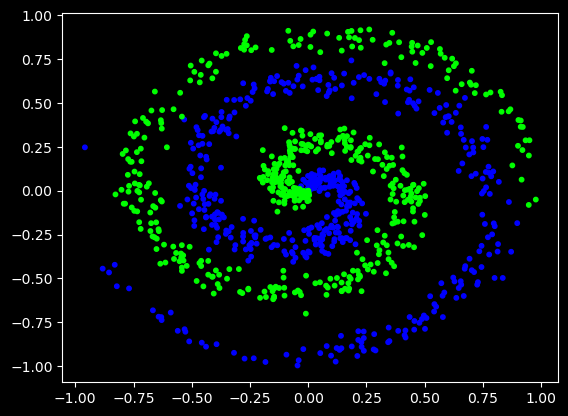

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="brg")

In [27]:
model = Model(1000)
model.add_dense(2, 512, ReLU, L2_weight_regularizer=5e-8, L2_bias_regularizer=5e-8)
# model.add_dropout()
model.add_dense(512, 1, Sigmoid)
model.add_loss(Binary_Cross_Entropy)
model.add_optimizer(Adam, learning_rate=0.02, decay=5e-7)
model.fit(X, y)

Epochs: 0, Acc: 0.5, Loss: 0.6931307911872864, Data_Loss: 0.6931307911872864, Reg_Loss: 4.826073318753288e-09, Lr: 0.02
Epochs: 100, Acc: 0.915, Loss: 0.3122987449169159, Data_Loss: 0.31228333711624146, Reg_Loss: 1.5403624274767935e-05, Lr: 0.0199990000499975
Epochs: 200, Acc: 0.966, Loss: 0.14729899168014526, Data_Loss: 0.14726388454437256, Reg_Loss: 3.510788519633934e-05, Lr: 0.019998000199980003
Epochs: 300, Acc: 0.983, Loss: 0.08626807481050491, Data_Loss: 0.08621805906295776, Reg_Loss: 5.0015427405014634e-05, Lr: 0.01999700044993251
Epochs: 400, Acc: 0.989, Loss: 0.059888534247875214, Data_Loss: 0.05982520431280136, Reg_Loss: 6.333160126814619e-05, Lr: 0.019996000799840034
Epochs: 500, Acc: 0.996, Loss: 0.0468221977353096, Data_Loss: 0.04674829915165901, Reg_Loss: 7.389867823803797e-05, Lr: 0.019995001249687578
Epochs: 600, Acc: 0.996, Loss: 0.03908678889274597, Data_Loss: 0.039003945887088776, Reg_Loss: 8.28445699880831e-05, Lr: 0.019994001799460162
Epochs: 700, Acc: 0.996, Loss:

True


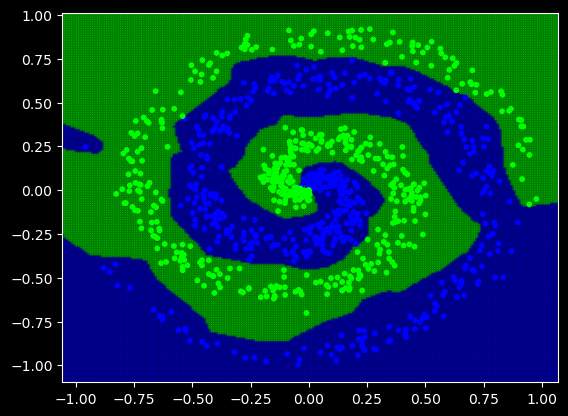

In [28]:
model.show_boundary()

In [29]:
X, y = spiral_data(samples=500, classes=3)

In [30]:
model = Model(12000)
model.add_dense(2, 124, ReLU, L2_weight_regularizer=5e-8, L2_bias_regularizer=5e-8)
# model.add_dropout()
model.add_dense(124, 3, Softmax)
model.add_loss(Categorical_Cross_Entropy)
model.add_optimizer(Adam, learning_rate=0.02, decay=5e-7)
model.fit(X, y)

Epochs: 0, Acc: 0.266, Loss: 1.0986612539391623, Data_Loss: 1.0986612526894095, Reg_Loss: 1.2497527457355773e-09, Lr: 0.02
Epochs: 100, Acc: 0.642, Loss: 0.8456418708896761, Data_Loss: 0.8456358141188046, Reg_Loss: 6.056770871509798e-06, Lr: 0.0199990000499975
Epochs: 200, Acc: 0.7666666666666667, Loss: 0.6112082736472707, Data_Loss: 0.6111907342802346, Reg_Loss: 1.7539367036079057e-05, Lr: 0.019998000199980003
Epochs: 300, Acc: 0.816, Loss: 0.4858078533402989, Data_Loss: 0.48578142868296376, Reg_Loss: 2.6424657335155644e-05, Lr: 0.01999700044993251
Epochs: 400, Acc: 0.8446666666666667, Loss: 0.41105874118959795, Data_Loss: 0.41102337144632506, Reg_Loss: 3.5369743272894993e-05, Lr: 0.019996000799840034
Epochs: 500, Acc: 0.866, Loss: 0.36285077754148065, Data_Loss: 0.3628068500169508, Reg_Loss: 4.392752452986315e-05, Lr: 0.019995001249687578
Epochs: 600, Acc: 0.8733333333333333, Loss: 0.3292778324265257, Data_Loss: 0.3292264091377021, Reg_Loss: 5.1423288823571056e-05, Lr: 0.019994001799

False


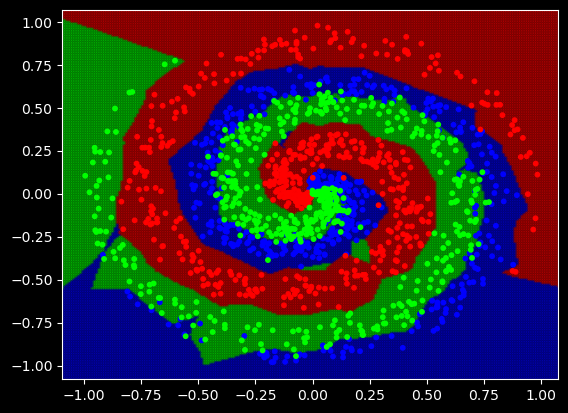

In [31]:
model.show_boundary()

In [32]:
X, y = sine_data()
model = Model(12000)
model.add_dense(1, 124, ReLU, L2_weight_regularizer=5e-8, L2_bias_regularizer=5e-8)
# model.add_dropout()
model.add_dense(124, 124, ReLU)

model.add_dense(124, 1, Linear)
model.add_loss(MSE)
model.add_optimizer(Adam, learning_rate=0.005, decay=1e-3)
model.fit(X, y)

Epochs: 0, Acc: 0.002, Loss: 0.5000258343636754, Data_Loss: 0.5000258336803332, Reg_Loss: 6.833423271679351e-10, Lr: 0.005
Epochs: 100, Acc: 0.03, Loss: 0.06375091080295292, Data_Loss: 0.06375089056591421, Reg_Loss: 2.023703871145699e-08, Lr: 0.004545454545454545
Epochs: 200, Acc: 0.077, Loss: 0.031090711264139075, Data_Loss: 0.031090668780021518, Reg_Loss: 4.248411755725101e-08, Lr: 0.004166666666666667
Epochs: 300, Acc: 0.108, Loss: 0.030759269990402915, Data_Loss: 0.030759221638950295, Reg_Loss: 4.835145261949947e-08, Lr: 0.003846153846153846
Epochs: 400, Acc: 0.545, Loss: 0.030708851964553304, Data_Loss: 0.030708802164602474, Reg_Loss: 4.9799950829765294e-08, Lr: 0.0035714285714285718
Epochs: 500, Acc: 0.575, Loss: 0.030706036639072867, Data_Loss: 0.030705986089492345, Reg_Loss: 5.054958052141956e-08, Lr: 0.003333333333333333
Epochs: 600, Acc: 0.593, Loss: 0.03070498832765839, Data_Loss: 0.03070493739878305, Reg_Loss: 5.0928875339195656e-08, Lr: 0.003125
Epochs: 700, Acc: 0.615, Lo

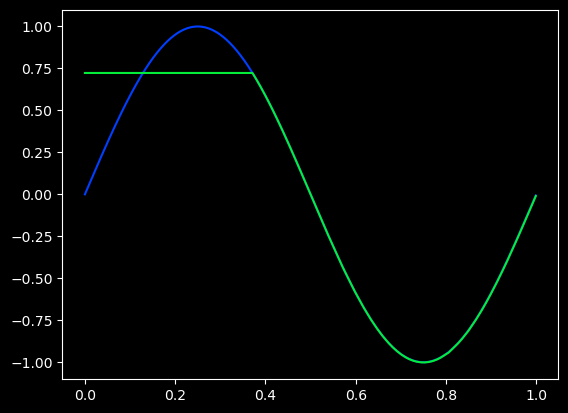

In [33]:
model.show_regression()